# Reading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os


data = []
labels = []
IMG_SIZE = 150
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Train'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Train/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    data.append(img)
    labels.append(i.split('_')[0])

print(len(data))
print(labels[0])

1681
Yoga


# Preprocessing

In [2]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
train_labels = le.fit_transform(labels)
train_labels = np_utils.to_categorical(train_labels, len(np.unique(train_labels)))

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(train_labels), test_size=0.20, random_state=42)

# normalize the data
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

print(len(trainX))
print(len(testX))

1344
337


# Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
train_gen = train_datagen.flow(trainX,trainY,batch_size=32)
print(len(train_gen))

42


# Model

In [4]:
import keras 
import tensorflow
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model

IMG = Input(shape=(IMG_SIZE , IMG_SIZE , 3))

layer_1 = Conv2D(5, (1,1), padding='same', activation='relu')(IMG)
layer_1 = Conv2D(5, (1,3), padding='same', activation='relu')(layer_1)
layer_1 = Conv2D(5, (3,1), padding='same', activation='relu')(layer_1)

layer_2 = Conv2D(5, (1,1), padding='same', activation='relu')(IMG)
layer_2 = Conv2D(5, (1,3), padding='same', activation='relu')(layer_2)
layer_2 = Conv2D(5, (3,1), padding='same', activation='relu')(layer_2)
layer_2 = Conv2D(5, (1,3), padding='same', activation='relu')(layer_2)
layer_2 = Conv2D(5, (3,1), padding='same', activation='relu')(layer_2)

layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(IMG)
layer_3 = Conv2D(5, (1,1), padding='same', activation='relu')(layer_3)
layer_3 = Dropout(0.25)(layer_3)


mid_1 = tensorflow.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)

flat_1 = Flatten()(mid_1)

dense_1 = Dense(1200, activation='relu')(flat_1)
dense_2 = Dense(600, activation='relu')(dense_1)
dense_3 = Dense(150, activation='relu')(dense_2)
output = Dense(6, activation='softmax')(dense_3)

model = Model([IMG], output)

model.summary()

2022-12-22 16:42:46.835427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:46.836495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:47.080487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:47.081527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:47.082312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 150, 150, 5)  20          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 150, 150, 5)  80          conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 5)  20          input_1[0][0]                    
______________________________________________________________________________________________

ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:47.332103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:47.332811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:47.333522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:42:51.956332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 200

checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early = EarlyStopping(monitor='val_loss',min_delta=0,patience=50,verbose=1,mode='auto')

history = model.fit(train_gen, epochs=epochs, validation_data=(testX, testY) ,callbacks=[checkpoint,early])

2022-12-22 16:42:52.766632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-22 16:42:55.599956: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


42/42 [==============================] - 23s 228ms/step - loss: 17.0021 - accuracy: 0.2820 - val_loss: 2.9958 - val_accuracy: 0.3828

Epoch 00001: val_loss improved from inf to 2.99577, saving model to model.h5


2022-12-22 16:43:15.797882: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.
2022-12-22 16:43:20.019213: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.
2022-12-22 16:43:23.415392: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.


Epoch 2/200
42/42 [==============================] - 9s 213ms/step - loss: 2.0411 - accuracy: 0.4159 - val_loss: 1.5371 - val_accuracy: 0.5312

Epoch 00002: val_loss improved from 2.99577 to 1.53710, saving model to model.h5


2022-12-22 16:44:25.008225: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.
2022-12-22 16:44:28.954011: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620000000 exceeds 10% of free system memory.


Epoch 3/200
42/42 [==============================] - 9s 217ms/step - loss: 1.4249 - accuracy: 0.5305 - val_loss: 1.2819 - val_accuracy: 0.5223

Epoch 00003: val_loss improved from 1.53710 to 1.28186, saving model to model.h5
Epoch 4/200
42/42 [==============================] - 9s 221ms/step - loss: 1.4784 - accuracy: 0.5149 - val_loss: 1.2302 - val_accuracy: 0.5668

Epoch 00004: val_loss improved from 1.28186 to 1.23023, saving model to model.h5
Epoch 5/200
42/42 [==============================] - 9s 213ms/step - loss: 1.2427 - accuracy: 0.5699 - val_loss: 1.0454 - val_accuracy: 0.6083

Epoch 00005: val_loss improved from 1.23023 to 1.04537, saving model to model.h5
Epoch 6/200
42/42 [==============================] - 9s 211ms/step - loss: 1.1107 - accuracy: 0.5908 - val_loss: 0.9597 - val_accuracy: 0.6083

Epoch 00006: val_loss improved from 1.04537 to 0.95973, saving model to model.h5
Epoch 7/200
42/42 [==============================] - 9s 215ms/step - loss: 1.0927 - accuracy: 0.6183

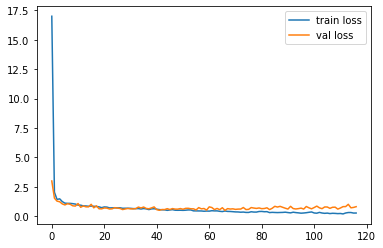

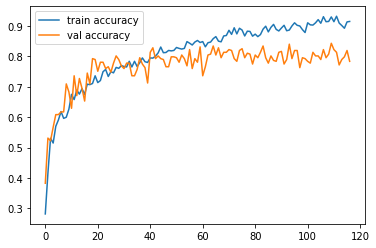

In [6]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

# evalutaion

In [7]:
model.evaluate(testX,testY)

11/11 [==============================] - 0s 22ms/step - loss: 0.8102 - accuracy: 0.7834


[0.8102130889892578, 0.783382773399353]

# Test Data

In [8]:
test_data = []
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Test'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Test/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    test_data.append(np.array(img))
test_data = np.array(test_data)
test_data = test_data/255.0

print(len(test_data))

688


# Prediction

In [9]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)
df = pd.DataFrame({'image_name':os.listdir('/kaggle/input/nn23-sports-image-classification/Test'),'Label':pred})
df.to_csv('submission.csv',index=False)
df

model.save('model.h5')
import pickle
f = open('label_encoder.pkl', "wb")
f.write(pickle.dumps(le))
f.close()